# Outlier generation

Wildboar is bundled with support for outlier detection. The primary focus is on detecting samples that deviate from what is expected, i.e., outlier samples, as opposed to detecting deviating patterns or time points. Since there are no good benchmark datasets for outlier detection (except for ``wildboar/outlier``), we support the constructing outlier datasets from traditional classification tasks.

In [1]:
import matplotlib.pylab as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

from wildboar.datasets import load_dataset
from wildboar.datasets.outlier import (
    kmeans_outliers,
    majority_outliers,
    minority_outliers,
    density_outliers,
    emmott_outliers,
)
from wildboar.embed import IntervalEmbedding
from wildboar.utils import plot

In [2]:
x, y = load_dataset("GunPoint")

In [3]:
def plot_inlier_outlier(x_outlier, y_outlier):
    label, value = np.unique(y_outlier, return_counts=True)
    fig = plt.figure(figsize=(8, 6))
    gs = plt.GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_title("Projection")
    plot_projection(x_outlier, y_outlier, ax=ax1)

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.set_title("Distribution")
    ax2.bar(label, value, color=plt.cm.get_cmap("Dark2", 2).colors)

    ax3 = fig.add_subplot(gs[1, 1])
    ax3.set_title("Time series")
    plot.plot_time_domain(x_outlier, y=y_outlier, ax=ax3)
    fig.tight_layout()

def plot_projection(x_outlier, y_outlier, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    pipe = make_pipeline(IntervalEmbedding(n_interval=15), PCA(2, random_state=123))
    projection = pipe.fit_transform(x_outlier, y_outlier)
    cmap = plt.cm.get_cmap("Dark2", 2)
    ax.scatter(
        projection[y_outlier == 1, 0],
        projection[y_outlier == 1, 1],
        marker="x",
        color=cmap(0),
    )
    ax.scatter(
        projection[y_outlier == -1, 0],
        projection[y_outlier == -1, 1],
        marker="x",
        color=cmap(1),
    )

## Minority labeler

The minority labeler defines the outlier class as the minority class of the training samples.

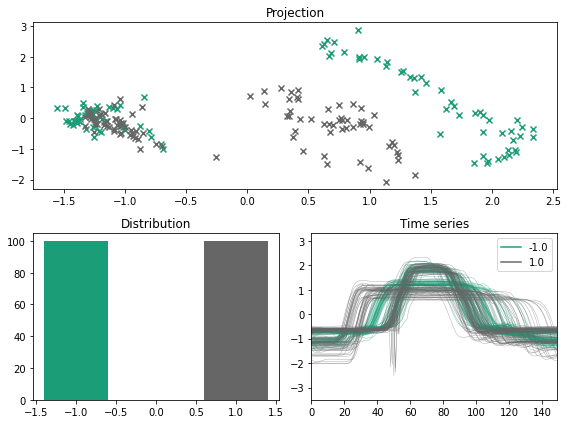

In [4]:
x_outlier, y_outlier = minority_outliers(x, y, n_outliers=None)
plot_inlier_outlier(x_outlier, y_outlier)

For a balanced dataset, the minority sampler fails to simulate outliers and inliers. As such, the user can specify a fraction of the resulting dataset that should be outliers.

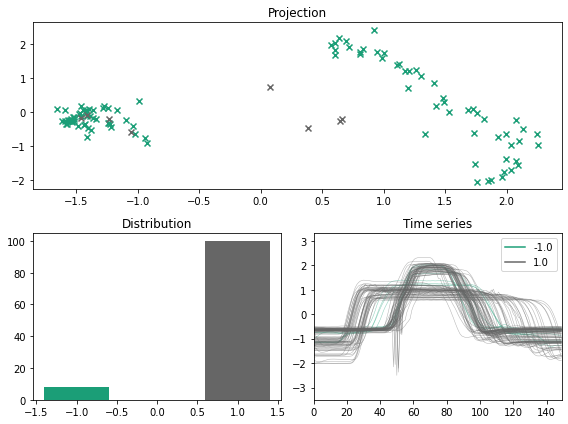

In [5]:
x_outlier, y_outlier = minority_outliers(x, y, n_outliers=0.07)
plot_inlier_outlier(x_outlier, y_outlier)

## Majority labeler

Another option is to simply consider the minority class as iniliers and then draw a (small) sample of the majority class and consider those as outliers. Compared to the minority labeler, this method is generally more suitable for generating outliers from multiclass problems.

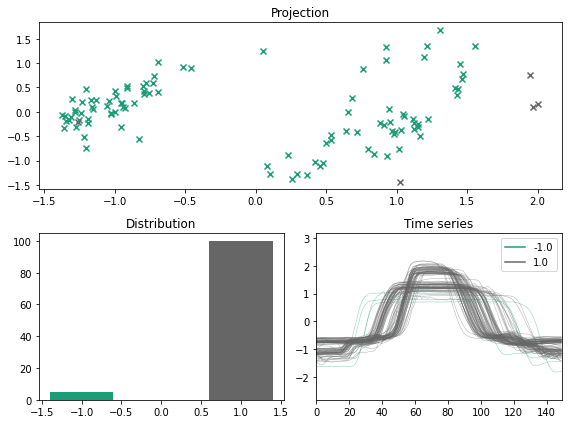

In [6]:
x_outlier, y_outlier = majority_outliers(x, y, n_outliers=0.05)
plot_inlier_outlier(x_outlier, y_outlier)

## KMeans labeler

A sligtly more refined approach is to construct k-clusters and and consider the cluster with the centroid farthest from the other clusters as the outlier label.


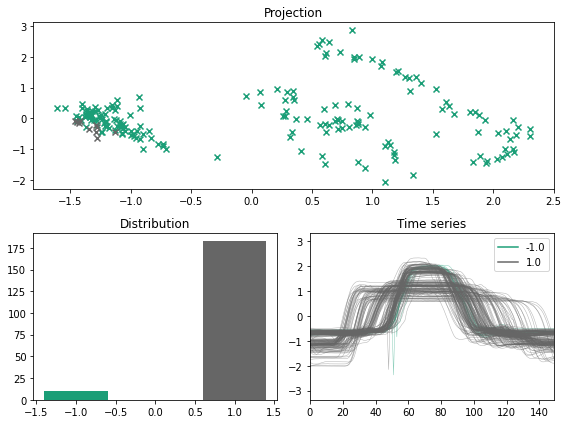

In [7]:
x_outlier, y_outlier = kmeans_outliers(x, n_outliers=0.05, n_clusters=20)
plot_inlier_outlier(x_outlier, y_outlier)

## Density labeler

Another approach is to consider density based clustering, and assign those samples which do not belong to a cluster as the outliers.

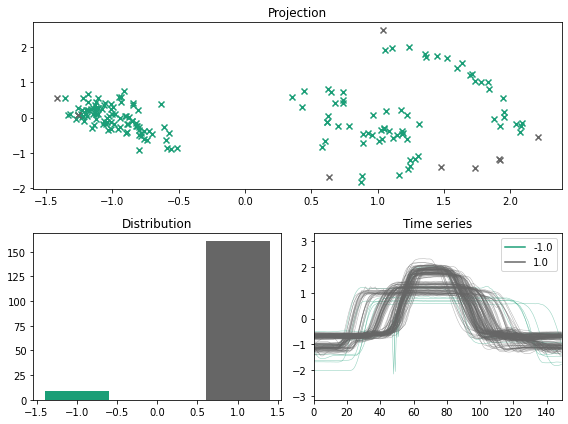

In [8]:
x_outlier, y_outlier = density_outliers(x, y, n_outliers=0.05, eps=2)
plot_inlier_outlier(x_outlier, y_outlier)

## EmottLabeler

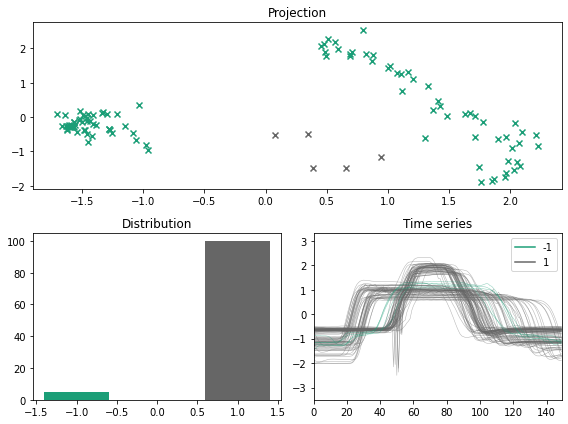

In [9]:
x_outlier, y_outlier = emmott_outliers(x, y, n_outliers=0.05, difficulty="simplest")
plot_inlier_outlier(x_outlier, y_outlier)

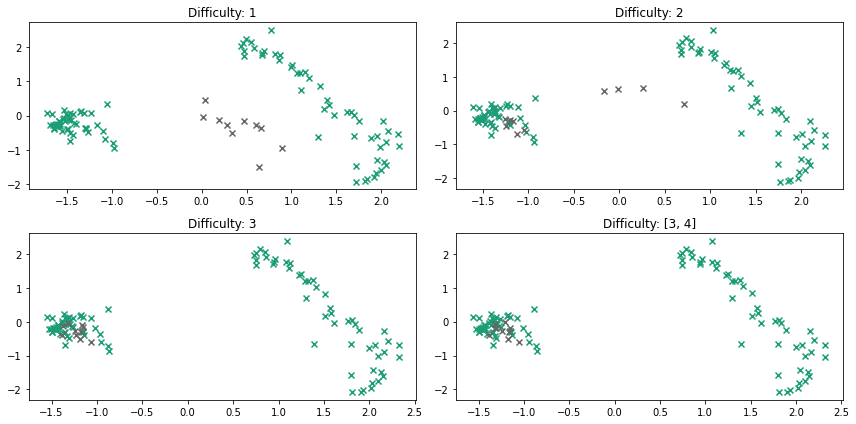

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2,  figsize=(12, 6))
ax = ax.flatten()
for i, difficulty in enumerate([1, 2, 3, [3, 4]]):
    x_outlier, y_outlier = emmott_outliers(
        x,
        y,
        n_outliers=0.1,
        variation="dispersed",
        difficulty=difficulty,
        random_state=123,
    )
    plot_projection(x_outlier, y_outlier, ax=ax[i])
    ax[i].set_title("Difficulty: %s" % str(difficulty))

fig.tight_layout()